In [2]:
# Initialization
import pyhdk 
import pandas
import time
import pyarrow as pa
import pyarrow.csv
import os, sys

config = pyhdk.buildConfig(enable_heterogeneous=True,
                           force_heterogeneous_distribution=True,
                           enable_multifrag_heterogeneous=True,
                           enable_debug_timer=False,)
# pyhdk.initLogger(log_severity="INFO")
storage = pyhdk.storage.ArrowStorage(1)
data_mgr = pyhdk.storage.DataMgr(config)
data_mgr.registerDataProvider(storage)

calcite = pyhdk.sql.Calcite(storage, config)
executor = pyhdk.Executor(data_mgr, config)

In [3]:
# Helper Functions
default_step = 50
default_iters = 3

def get_rel_alg(sql):
    return calcite.process(sql)

def run_query(sql):
    ra = get_rel_alg(sql)
    # One RelAlgExecutor per query
    rel_alg_executor = pyhdk.sql.RelAlgExecutor(executor, storage, data_mgr, ra)
    return rel_alg_executor.execute()


def import_hdk_pyarrow(storage, arrow_table, hdk_table_name, fragment_size, overwrite=True):
    """
    Imports a pyarrow table to HDK with the given fragment size.
        overwrite: By default overwrites previously existing table.
    """
    opt = pyhdk.storage.TableOptions(fragment_size)
    start_timer = time.perf_counter()
    try:
        storage.importArrowTable(arrow_table, hdk_table_name, opt)
    except:
        if not overwrite:
            raise Exception(f"Cannot overwrite table{hdk_table_name}, overwrite={overwrite}")
        storage.dropTable(hdk_table_name)
        storage.importArrowTable(arrow_table, hdk_table_name, opt)
    print(f"[PyHDK] Importing pyarrow table: {(time.perf_counter()-start_timer):.4f}s")


def run_query_het_all_props(sql, query_name="", prop_step=default_step, n_iters=default_iters, clear_memory_devices=[]):
    """
    Runs SQL query multiple times at each proportion, feel free try and experiment with loops order.
        clear_memory_devices: clear memory of the device manager: 1:CPU, 2:GPU 
    """
    cython_enum_dict = {"CPU":1, "GPU":1} # May move up to cython for easier interface
    ra = get_rel_alg(sql)
    col_names = ["CPU_prop", f"QueryT_{query_name}"]
    prop_time = {col_names[0] : [], col_names[1]: []}
    # Walking over proportions
    for cpu_prop in range(0, 101, prop_step):
        config.setCpuProp(cpu_prop)
        # Multiple iterations
        for _ in range(1, n_iters + 1):
            rel_alg_executor = pyhdk.sql.RelAlgExecutor(executor, storage, data_mgr, ra)
            query_start = time.perf_counter()
            result = rel_alg_executor.execute()
            query_finish = time.perf_counter()
            prop_time[col_names[0]].append(cpu_prop)
            prop_time[col_names[1]].append(query_finish - query_start)
            [executor.clearMemory(data_mgr, cython_enum_dict[device]) for device in clear_memory_devices]

        df_prop_time = pandas.DataFrame(prop_time, columns=col_names)
    # Some metadata to get idea about the output cardinality
    df_output = result.to_arrow().to_pandas()
    output_size_KB = df_output.memory_usage(index=True).sum() // (1024)
    df_prop_time.rename(columns={col_names[1]:f"{col_names[1]}_{output_size_KB}KB"}, inplace=True)
    return [df_prop_time, df_output]

def run_queries_all_props(query_dict, step=default_step, n_iters=default_iters, clear_memory_devices=[]):
    """
    Runs query dictionary of SQL queries with the following structure: dict(query_name:{SQL_string})
        clear_memory_devices: clear memory of the device manager after each query: "CPU", "GPU" 
    """
    q_timings_dict = dict()
    for q_name in query_dict:
        [df_prop_time, df_output] = run_query_het_all_props(query_dict[q_name], 
                                                            query_name=q_name, 
                                                            prop_step=step, 
                                                            n_iters=n_iters, 
                                                            clear_memory_devices=clear_memory_devices)
        df_prop_time.set_index("CPU_prop", inplace=True)
        q_timings_dict[q_name] = (df_prop_time)
    return q_timings_dict

def fragment_size_calc(num_rows):
    """Taken from Modin, you can experiment with it."""
    cpu_count = os.cpu_count()
    if cpu_count is not None:
        fragment_size = num_rows // cpu_count
        fragment_size = min(fragment_size, 2**25)
        fragment_size = max(fragment_size, 2**18)
        return fragment_size
    else:
        return None

def fragment_size_test_range(num_rows):
    """
    Take two power of two steps around default frag_size: [x/4,x/2,x,x*2,x*4].
    """
    res_range = []
    default_fragment_size = fragment_size_calc(num_rows)
    print(f"Default fragment_size={default_fragment_size}")
    power_two_steps = 2
    range_start = default_fragment_size//(2**power_two_steps)
    range_end = default_fragment_size*(2**power_two_steps)
    fragment_size = range_start
    while fragment_size < range_end+1:
        res_range.append(fragment_size)
        fragment_size *= 2
    return res_range

def test_groups_fragment_sizes(storage, pyarrow_tbl, table_name, q_dict, step, n_iters):
    """ 
    Produces the follwing result grouping: fragment_size{query_name{timings_df}}
    """
    part_group_timings_dict = dict()
    for frag_size in fragment_size_test_range(pyarrow_tbl.num_rows):
        table_size_MB = pyarrow_tbl.nbytes // (1024*1024)
        print(f"Testing {table_size_MB}MB Table with Frag.size={frag_size}")
        import_hdk_pyarrow(storage, pyarrow_tbl, table_name, frag_size)
        part_group_timings_dict[f"Tbl_size_{table_size_MB}MB_frag_size_{frag_size}"] = run_queries_all_props(q_dict, step, n_iters)
    return part_group_timings_dict

In [4]:
# Read data
dataset_path = "some/path/myFile.csv"
table_name = "taxi"
# If the CSV does not have a header, please provide the column names.
pyarrow_tbl = pa.csv.read_csv(dataset_path)

In [11]:
# Queries (NY Taxi example)
select_queries = {
    "simple_select" : f"SELECT * FROM {table_name};",
    "select_less" : f"SELECT * FROM {table_name} WHERE rate_code_id > 1;",
}

groupby_queries = {
    "simple_groupby" : f"SELECT Count(*) FROM {table_name} GROUP BY rate_code_id;",
    "group_by_larger" : f"SELECT total_amount, COUNT(*) FROM {table_name} GROUP BY total_amount;",
}

taxi_q = {
    "Q1": f"SELECT cab_type, count(*)\
            FROM {table_name}\
            GROUP BY cab_type;",
    "Q2": f"SELECT passenger_count, avg(total_amount)\
            FROM {table_name}\
            GROUP BY passenger_count;",
    "Q3": f"SELECT passenger_count, extract(year from pickup_datetime) as pickup_year, count(*)\
            FROM {table_name}\
            GROUP BY passenger_count, extract(year from pickup_datetime);",
    "Q4": f"SELECT passenger_count,\
                extract(year from pickup_datetime) as pickup_year,\
                cast(trip_distance as int) AS distance,\
                count(*) AS the_count\
            FROM {table_name}\
            GROUP BY passenger_count,\
                    pickup_year,\
                    distance\
            ORDER BY passenger_count, pickup_year, distance, the_count;"
}

In [12]:
# Run Queries (kernel may crush, HDK-side issues)
default_fragment_size = fragment_size_calc(pyarrow_tbl.num_rows)
import_hdk_pyarrow(storage, pyarrow_tbl, table_name, default_fragment_size)

select_queries_timings = run_queries_all_props(select_queries,10,3)
groupby_queries_timings = run_queries_all_props(groupby_queries,10,10,clear_memory_devices=["CPU", "GPU"])
taxi_queries_timings = run_queries_all_props(taxi_q,10,3)


[PyHDK] Importing pyarrow table: 0.0106s


In [13]:
taxi_frags = test_groups_fragment_sizes(storage, pyarrow_tbl, table_name, taxi_q, 10, 2)

Default fragment_size=262144
Testing 0MB Table with Frag.size=65536
[PyHDK] Importing pyarrow table: 0.0177s
Testing 0MB Table with Frag.size=131072
[PyHDK] Importing pyarrow table: 0.0079s
Testing 0MB Table with Frag.size=262144
[PyHDK] Importing pyarrow table: 0.0063s
Testing 0MB Table with Frag.size=524288
[PyHDK] Importing pyarrow table: 0.0073s
Testing 0MB Table with Frag.size=1048576
[PyHDK] Importing pyarrow table: 0.0056s


In [8]:
import importlib.util
if importlib.util.find_spec("matplotlib") is None:
    raise Exception("Please install matplotlib")

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,4)
styles = ['s-','o-','^-','+-','*-',',-']

def plotTimings(dict_of_df_timings, plot_name="Time vs CPU proportion"):
    ylab = "Time (s)"
    xlab = "Data proportion on CPU (%)"
    df_accumulator = None
    for q_name in dict_of_df_timings:
        df_agg = dict_of_df_timings[q_name].groupby(["CPU_prop"]).median()
        if df_accumulator is None:
            df_accumulator = df_agg
        else:
            df_accumulator = df_accumulator.merge(df_agg, on=["CPU_prop"])
    df_accumulator.plot(xlabel=xlab, ylabel=ylab, title=plot_name)
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()


def swap_dict_levels(dict_frag_to_q):
    """ 
    Normally, we have the following grouping: 
        query_name{timings_df}, 
    for fragments we have:
        fragment_size{query_name{timings_df}},
    so to make plotting taxi queries simpler, we change it to:
        query_name{fragment_size{timings_df}}, 
    feel free to change the query grouping structure.
    """
    transformed_q_frag = dict()
    for frag_size, q_values in dict_frag_to_q.items():
        for q, value in q_values.items():
            if q not in transformed_q_frag:
                transformed_q_frag[q] = value
            else:
                transformed_q_frag[q] = pandas.concat([transformed_q_frag[q], value], axis=1)
            l = transformed_q_frag[q].columns.tolist()
            transformed_q_frag[q] = transformed_q_frag[q].rename(columns={l[-1] :l[-1]+ f"_{frag_size}"})
    return transformed_q_frag

def plotTimingsFrags(dict_of_df_timings, plot_name="Time vs CPU proportion"):
    ylab = "Time (s)"
    xlab = "Data proportion on CPU (%)"
    fig, axes = plt.subplots(len(dict_of_df_timings),1)
    fig.set_size_inches(7,9)
    for enum, q_name in enumerate(dict_of_df_timings):
        df_agg = dict_of_df_timings[q_name].groupby(["CPU_prop"]).median()
        # Cut redundand query info
        df_agg.rename(columns=lambda x: '_'.join(x.split('_')[-3:]), inplace=True)
        subplot_title = q_name
        df_agg.plot(ax=axes[enum], xlabel=xlab, ylabel=ylab, title=subplot_title, style=styles[enum])
        axes[enum].legend(bbox_to_anchor=(1.01, 1.02), loc="upper left")

    fig.tight_layout()
    fig.show()

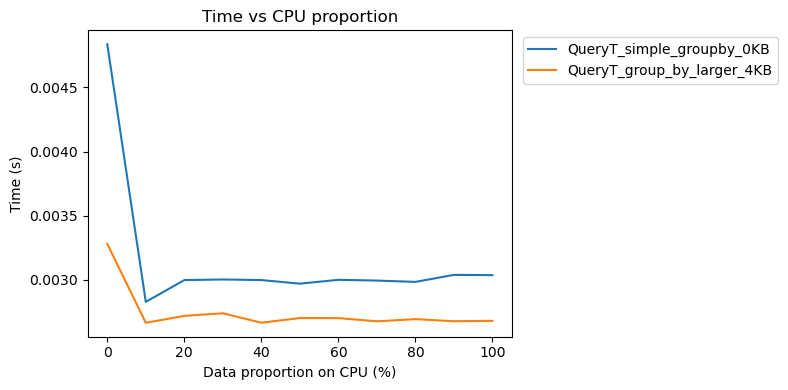

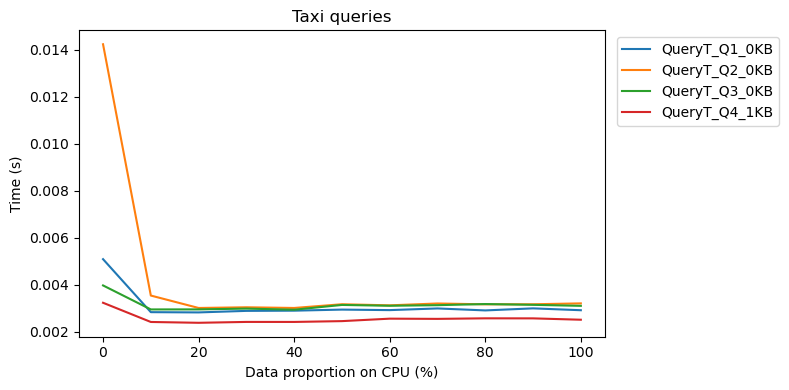

In [9]:
plotTimings(groupby_queries_timings)
plotTimings(taxi_queries_timings, "Taxi queries")

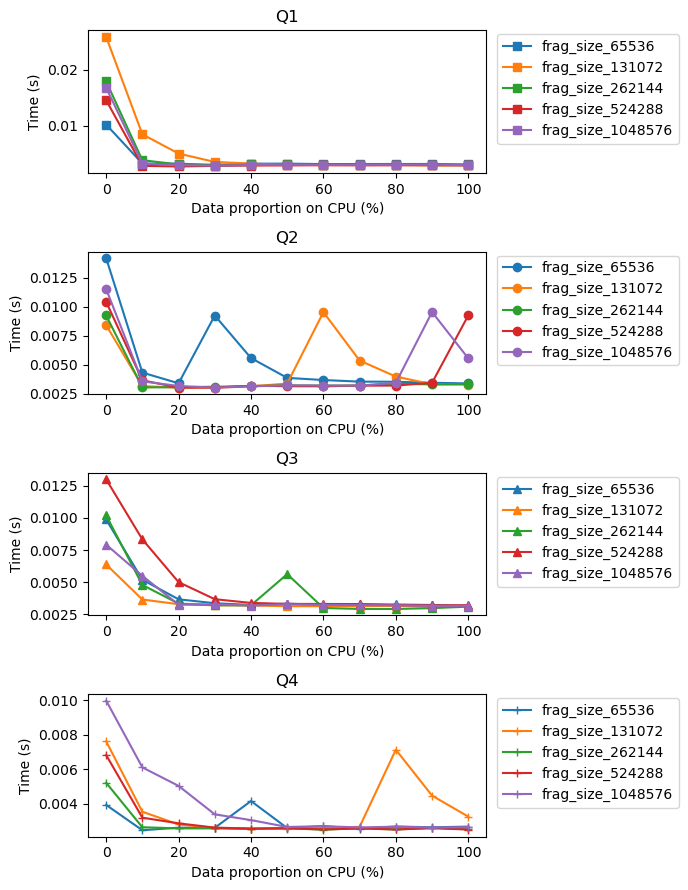

In [10]:
plotTimingsFrags(swap_dict_levels(taxi_frags))

In [ ]:
# HDK Cleanup
storage.dropTable(table_name)